In [1]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
''' NOTES:
For company A, I did not run a time series on entire dataset for access or application issue
For company J, I did not run a time series for the category 'Telephone & Conference (Audio, Video)' due to less than 100 tickets
'''

In [2]:
#Import Packages
import pandas as pd
import numpy as np
from scipy.stats import uniform # for training-and-test split
import statsmodels.api as sm # statistical models (including regression)
import statsmodels.formula.api as smf # R-like model specification
import matplotlib.pyplot as plt # 2D plotting
import seaborn as sns # PROVIDES TRELLIS AND SMALL MULTIPLE PLOTTING
from pathlib import Path # for merging dataframes
from sklearn.preprocessing import LabelEncoder #to numberize columns
from sklearn.preprocessing import OneHotEncoder #another way to numberize object columns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
#import required packages
import re
from pprint import pprint
import nltk; nltk.download('stopwords')
import sklearn
import datetime
from datetime import datetime, timedelta
from pandas import DataFrame
import sys
! {sys.executable} -m pip install progress #progress bars
from progress.bar import Bar

pd.set_option("display.max_colwidth", 200)

#gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy for lemmatization
import sys
! {sys.executable} -m pip install spacy
! {sys.executable} -m pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz
import spacy 


#from spacy_langdetect import LanguageDetector
#nlp = spacy.load('en')
#nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)

# Plotting tools
! {sys.executable} -m pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
  Created wheel for progress: filename=progress-1.5-cp36-none-any.whl size=8074 sha256=d6daf22cd4b7f1668ecebbaa91fbbcfb1904be7b234aa321b2428d8429ae6af4
  Stored in directory: /root/.cache/pip/wheels/6c/c8/80/32a294e3041f006c661838c05a411c7b7ffc60ff939d14e116
Successfully built progress
     |████████████████████████████████| 12.0MB 3.7MB/s 
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.0-cp36-none-any.whl size=12019126 sha256=95aa6140488d68c9189816e741936cf120c47725b1ffb3305d8f89b2abc7a35e
  Stored in directory: /root/.cache/pip/wheels/48/5c/1c/15f9d02afc8221a668d2172446dd8467b20cdb9aef80a172a4
Successfully built en-core-web-sm
  Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
     |████████████████████████████████| 1.6MB 5.5MB/s 
  Created wheel for pyLDAvis: filenam

# COMPANY A - EDA

In [3]:
# COMPANY A
# Read in data:

a_data = pd.read_csv('/content/gdrive/Shared drives/IST 718 Project/a_cleaned.csv')
#a_data.head()

In [5]:
a_data['category'] =  a_data['u_actual_category'].astype(str)
a_data['subcategory'] =  a_data['u_actual_subcategory'].astype(str)
a_data['opened_at'] = pd.to_datetime(a_data.opened_at)
a_data['Date'] = a_data['opened_at'].dt.strftime('%Y-%m')
print(a_data)

       Unnamed: 0  Unnamed: 0.1  ...            subcategory     Date
0               0             0  ...      software breakfix  2020-10
1               3             3  ...  bitlocker - break/fix  2020-10
2               4             4  ...      software breakfix  2020-10
3               6             6  ...             windows 10  2020-10
4               8             9  ...      software breakfix  2020-10
...           ...           ...  ...                    ...      ...
99322      101300        105187  ...   computer break / fix  2018-08
99323      101301        105188  ...    other-issue / error  2018-06
99324      101302        105189  ...           email-access  2018-06
99325      101303        105190  ...    other-issue / error  2018-03
99326      101304        105191  ...      software breakfix  2017-09

[99327 rows x 61 columns]


In [5]:
'''
Company A
selcat = ['access-issue/request', 'software', 'application-issue/request', 'general', 'email', 'computer hardware']
'''

"\n#Company A\nselcat = ['access-issue/request', 'software', 'application-issue/request', 'general', 'email', 'computer hardware']\n\n#Company J\nselcat = ['Desktop or laptop', 'Access and passwords', 'Application support', 'Infrastructure services', 'Easy connect', 'Telephone & Conference (Audio, Video)']\n"

In [7]:
# CATEGORY: General
a_data_general = pd.DataFrame(a_data.loc[a_data.category == 'general'])
print(a_data_general)
#print(a_data_general.columns)

       Unnamed: 0  Unnamed: 0.1  ...                      subcategory     Date
48             83            88  ...  general - hang up or disconnect  2020-10
109           151           158  ...  general - hang up or disconnect  2020-10
110           152           159  ...                 general - how to  2020-10
132           174           183  ...  general - hang up or disconnect  2020-10
138           180           191  ...                 general - how to  2020-10
...           ...           ...  ...                              ...      ...
99282      101260        105147  ...                 general - how to  2019-04
99283      101261        105148  ...                 general - how to  2019-04
99289      101267        105154  ...                    other-request  2019-04
99323      101301        105188  ...              other-issue / error  2018-06
99325      101303        105190  ...              other-issue / error  2018-03

[3964 rows x 61 columns]


In [8]:
#a_data_general= a_data_general.groupby(["subcategory"])["Date"].count()
a_data_general = a_data_general.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'assignment_group',
       'number', 'state', 'priority', 'short_description', 'description',
       'comments_and_work_notes', 'work_notes', 'close_notes', 'location',
       'sys_created_on', 'closed_at', 'u_initial_response_sla_completed',
       'bus_dur_num', 'reassignment_count', 'sys_mod_count',
       'assigned_to', 'closed_by', 'contact_type', 'sys_created_by', 'sla_due',
       'u_task_number_flag', 'sys_class_name', 'sys_updated_on',
       'sys_updated_by', 'urgency', 'work_start', 'active',
       'comments', 'closed_by.average_daily_fte', 'closed_by.city',
       'activity_due', 'approval', 'location.city', 'impact', 'knowledge',
       'u_reason_to_hold', 'location.country', 'location.u_location_id',
       'location.state', 'location.u_region', 'u_actual_category',
       'u_actual_subcategory', 'u_cause', 'u_cause_code', 'u_qs_fcresolve',
       'u_misrouted', 'due_date', 'sys_domain', 'task_effective_number',
       'TicketDuration', 'CalendarDuration', 'BusinessDuration', 'category','opened_at'], axis=1)

print(a_data_general)

       cal_dur_num                      subcategory     Date
48            7352  general - hang up or disconnect  2020-10
109            114  general - hang up or disconnect  2020-10
110            183                 general - how to  2020-10
132            171  general - hang up or disconnect  2020-10
138            423                 general - how to  2020-10
...            ...                              ...      ...
99282     34063409                 general - how to  2019-04
99283     34201093                 general - how to  2019-04
99289     36460990                    other-request  2019-04
99323     58755173              other-issue / error  2018-06
99325     63167158              other-issue / error  2018-03

[3964 rows x 3 columns]


In [8]:
a_data_general['subcategory'].value_counts()

general - how to                   2486
other-issue / error                 579
general - hang up or disconnect     458
other-request                       378
general - wrong number               32
general - test                       30
vpn 2fa - registration                1
Name: subcategory, dtype: int64

In [131]:
#a_data_general = a_data_general.groupby([a_data_general['Date']])['subcategory'].count()

# Subcategory: general-how to
general_how_to = a_data_general[a_data_general.subcategory =='general - how to']
general_how_to = pd.DataFrame(general_how_to.groupby([a_data_general['Date']])['subcategory'].count())
general_how_to.reset_index(inplace=True)
general_how_to.columns = ["Date", "Count-general how-to"]
general_how_to.loc[-1] = ['2019-03', 0] 
general_how_to.index = general_how_to.index + 1
general_how_to = general_how_to.sort_index()
#print(general_how_to)


In [134]:
# Subcategory: other-issue / error
general_error = a_data_general[a_data_general.subcategory =='other-issue / error']
general_error = pd.DataFrame(general_error.groupby([a_data_general['Date']])['subcategory'].count())
general_error = general_error[-17:]
general_error.reset_index(inplace=True)
general_error.columns = ["Date", "Count-error"]
general_error.loc[-1] = ['2019-05', 0] 
general_error.index = general_error.index + 1
general_error.loc[-1] = ['2019-04', 0] 
general_error.index = general_error.index + 1
general_error.loc[-1] = ['2019-03', 0] 
general_error.index = general_error.index + 1
general_error = general_error.sort_index()
#print(general_error)

# Subcategory: general - hang up or disconnect
disconnect = a_data_general[a_data_general.subcategory =='general - hang up or disconnect']
disconnect = pd.DataFrame(disconnect.groupby([a_data_general['Date']])['subcategory'].count())
disconnect.reset_index(inplace=True)
disconnect.columns = ["Date", "Count-disconnect"]
disconnect.loc[-1] = ['2019-11', 0] 
disconnect.index = disconnect.index + 1
disconnect.loc[-1] = ['2019-10', 0] 
disconnect.index = disconnect.index + 1
disconnect.loc[-1] = ['2019-09', 0] 
disconnect.index = disconnect.index + 1
disconnect.loc[-1] = ['2019-08', 0] 
disconnect.index = disconnect.index + 1
disconnect.loc[-1] = ['2019-07', 0] 
disconnect.index = disconnect.index + 1
disconnect.loc[-1] = ['2019-06', 0] 
disconnect.index = disconnect.index + 1
disconnect.loc[-1] = ['2019-05', 0] 
disconnect.index = disconnect.index + 1
disconnect.loc[-1] = ['2019-04', 0] 
disconnect.index = disconnect.index + 1
disconnect.loc[-1] = ['2019-03', 0] 
disconnect.index = disconnect.index + 1
disconnect = disconnect.sort_index()
#print(disconnect)

# Subcategory: other-request
request = a_data_general[a_data_general.subcategory =='other-request']
request = pd.DataFrame(request.groupby([a_data_general['Date']])['subcategory'].count())
request.reset_index(inplace=True)
request.columns = ["Date", "Count-request"]
request.loc[-1] = ['2019-03', 0] 
request.index = request.index + 1
request = request.sort_index()
request.loc[-1] = ['2019-05', 0] 
request.index = request.index + 1
request.loc[-1] = ['2019-10', 0] 
request.index = request.index + 1
request = request.reindex([2,3,1,4,5,6,7,0,8,9,10,11,12,13,14,15,16])
request.reset_index(inplace=True)
del request['index']
#print(request)

'''
# Subcategory: general - wrong number
wrong_number = a_data_general[a_data_general.subcategory =='general - wrong number']
wrong_number = pd.DataFrame(wrong_number.groupby([a_data_general['Date']])['subcategory'].count())
wrong_number.reset_index(inplace=True)
wrong_number.columns = ["Date", "Count-wrong number"]

# Subcategory: general - test
general_test = a_data_general[a_data_general.subcategory =='general - test']
general_test = pd.DataFrame(general_test.groupby([a_data_general['Date']])['subcategory'].count())
general_test.reset_index(inplace=True)
general_test.columns = ["Date", "Count-test"]

# Subcategory: vpn 2fa - registration
vpn_registration = a_data_general[a_data_general.subcategory =='vpn 2fa - registration']
vpn_registration = pd.DataFrame(vpn_registration.groupby([a_data_general['Date']])['subcategory'].count())
vpn_registration.reset_index(inplace=True)
vpn_registration.columns = ["Date", "Count-VPN registration"]
'''

'\n# Subcategory: general - wrong number\nwrong_number = a_data_general[a_data_general.subcategory ==\'general - wrong number\']\nwrong_number = pd.DataFrame(wrong_number.groupby([a_data_general[\'Date\']])[\'subcategory\'].count())\nwrong_number.reset_index(inplace=True)\nwrong_number.columns = ["Date", "Count-wrong number"]\n\n# Subcategory: general - test\ngeneral_test = a_data_general[a_data_general.subcategory ==\'general - test\']\ngeneral_test = pd.DataFrame(general_test.groupby([a_data_general[\'Date\']])[\'subcategory\'].count())\ngeneral_test.reset_index(inplace=True)\ngeneral_test.columns = ["Date", "Count-test"]\n\n# Subcategory: vpn 2fa - registration\nvpn_registration = a_data_general[a_data_general.subcategory ==\'vpn 2fa - registration\']\nvpn_registration = pd.DataFrame(vpn_registration.groupby([a_data_general[\'Date\']])[\'subcategory\'].count())\nvpn_registration.reset_index(inplace=True)\nvpn_registration.columns = ["Date", "Count-VPN registration"]\n'

In [135]:
generalTimeSeries = pd.DataFrame(general_how_to)
generalTimeSeries["Count-error"] = general_error["Count-error"]
generalTimeSeries["Count-disconnect"] = disconnect["Count-disconnect"]
generalTimeSeries["Count-request"] = request["Count-request"]
#generalTimeSeries["Count-wrong number"] = wrong_number["Count-wrong number"]
#generalTimeSeries["Count-test"] = general_test["Count-test"]
#generalTimeSeries["Count-VPN registration"] = vpn_registration["Count-VPN registration"]

print(generalTimeSeries)

       Date  Count-general how-to  Count-error  Count-disconnect  Count-request
0   2019-03                     0            0                 0            0.0
1   2019-04                    10            0                 0            1.0
2   2019-05                     9            0                 0            0.0
3   2019-06                    19            5                 0            2.0
4   2019-07                    25            2                 0            1.0
5   2019-08                    33            2                 0            1.0
6   2019-09                    26           15                 0            3.0
7   2019-10                    15            3                 0            0.0
8   2019-11                     7           14                 0            4.0
9   2019-12                    38           25                 1            7.0
10  2020-01                   246           62                15           65.0
11  2020-02                   271       

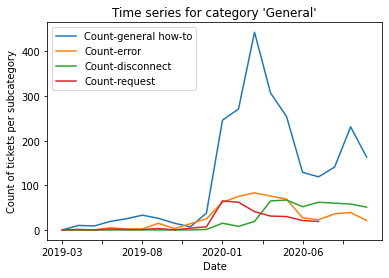

In [136]:
generalTimeSeries.plot(x='Date').set(title="Time series for category 'General'", xlabel="Date", ylabel="Count of tickets per subcategory")
plt.show()

In [9]:
a_data2 = a_data.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'assignment_group',
       'number', 'state', 'priority', 'short_description', 'description',
       'comments_and_work_notes', 'work_notes', 'close_notes', 'location',
       'sys_created_on', 'closed_at', 'u_initial_response_sla_completed',
       'bus_dur_num', 'reassignment_count', 'sys_mod_count',
       'assigned_to', 'closed_by', 'contact_type', 'sys_created_by', 'sla_due',
       'u_task_number_flag', 'sys_class_name', 'sys_updated_on',
       'sys_updated_by', 'urgency', 'work_start', 'active',
       'comments', 'closed_by.average_daily_fte', 'closed_by.city',
       'activity_due', 'approval', 'location.city', 'impact', 'knowledge',
       'u_reason_to_hold', 'location.country', 'location.u_location_id',
       'location.state', 'location.u_region', 'u_actual_category',
       'u_actual_subcategory', 'u_cause', 'u_cause_code', 'u_qs_fcresolve',
       'u_misrouted', 'due_date', 'sys_domain', 'task_effective_number',
       'TicketDuration', 'CalendarDuration', 'BusinessDuration', 'category','opened_at', 'cal_dur_num'], axis=1)

# Category: 'access-issue/request'
a_data_access_issue = pd.DataFrame(a_data2.loc[a_data.category == 'access-issue/request'])
a_data_access_issue['subcategory'].value_counts()

active directory - password reset                     6639
vpn 2fa - anyconnect how to                           4538
vpn 2fa - registration                                4149
login / password issue                                3343
vpn - certificate                                     3134
okta self pwd registration                            3128
active directory - account locked                     2988
temp admin rights                                     2500
shared folder / net drive - mapping                   1964
active directory - update                             1622
shared folder / net drive - other break / fix         1246
okta verify enrollment/mfa reset                      1142
shared folder / network drive-break / fix             1093
vpn / 2fa-break/fix                                    871
vpn - globalprotect - install/how to/configuration     722
vpn / 2fa-set up                                       666
vpn 2fa - access request                               6

In [327]:
# Subcategory: active directory - password reset
access_pwd_reset = a_data_access_issue[a_data_access_issue.subcategory =='active directory - password reset']
access_pwd_reset = pd.DataFrame(access_pwd_reset.groupby([a_data_access_issue['Date']])['subcategory'].count())
access_pwd_reset.reset_index(inplace=True)
access_pwd_reset.columns = ["Date", "Count-password reset"]
access_pwd_reset.loc[-1] = ['2019-11', 0] 
access_pwd_reset.index = access_pwd_reset.index + 1
access_pwd_reset = access_pwd_reset.reindex([1,2,3,4,5,6,7,0,8,9,10,11,12,13,14,15,16,17])
access_pwd_reset.reset_index(inplace=True)
del access_pwd_reset['index']
access_pwd_reset = access_pwd_reset[-15:]
access_pwd_reset.reset_index(inplace=True)
del access_pwd_reset['index']
access_pwd_reset.loc[15] = ['2020-10', 0] 
#print(access_pwd_reset)

# Subcategory: vpn 2fa - anyconnect how to 
access_vpn_anyconnect = a_data_access_issue[a_data_access_issue.subcategory =='vpn 2fa - anyconnect how to']
access_vpn_anyconnect = pd.DataFrame(access_vpn_anyconnect.groupby([a_data_access_issue['Date']])['subcategory'].count())
access_vpn_anyconnect.reset_index(inplace=True)
access_vpn_anyconnect.columns = ["Date", "Count-vpn anyconnect how to"]
#print(access_vpn_anyconnect)

# Subcategory: vpn 2fa - registration 
access_vpn_registration = a_data_access_issue[a_data_access_issue.subcategory =='vpn 2fa - registration']
access_vpn_registration = pd.DataFrame(access_vpn_registration.groupby([a_data_access_issue['Date']])['subcategory'].count())
access_vpn_registration.reset_index(inplace=True)
access_vpn_registration.columns = ["Date", "Count-vpn registration"]
access_vpn_registration.loc[-1] = ['2019-10', 0] 
access_vpn_registration.index = access_vpn_registration.index + 1
access_vpn_registration = access_vpn_registration.reindex([1,2,3,4,0,5,6,7,8,9,10,11,12,13,14,15,16])
access_vpn_registration.reset_index(inplace=True)
del access_vpn_registration['index']
access_vpn_registration = access_vpn_registration[-16:]
access_vpn_registration.reset_index(inplace=True)
del access_vpn_registration['index']
#print(access_vpn_registration)

# Subcategory: login / password issue 
access_password_issue = a_data_access_issue[a_data_access_issue.subcategory =='login / password issue']
access_password_issue = pd.DataFrame(access_password_issue.groupby([a_data_access_issue['Date']])['subcategory'].count())
access_password_issue.reset_index(inplace=True)
access_password_issue.columns = ["Date", "Count-password issue"]
access_password_issue = access_password_issue[-17:]
access_password_issue.reset_index(inplace=True)
del access_password_issue['index']
#print(access_password_issue)

# Subcategory: vpn - certificate
access_vpn_certificate = a_data_access_issue[a_data_access_issue.subcategory =='vpn - certificate']
access_vpn_certificate = pd.DataFrame(access_vpn_certificate.groupby([a_data_access_issue['Date']])['subcategory'].count())
access_vpn_certificate.reset_index(inplace=True)
access_vpn_certificate.columns = ["Date", "Count-vpn certificate"]
access_vpn_certificate.loc[-1] = ['2019-10', 0] 
access_vpn_certificate.index = access_vpn_certificate.index + 1
access_vpn_certificate = access_vpn_certificate.reindex([1,2,3,4,5,6,0,7,8,9,10,11,12,13,14,15,16,17,18])
access_vpn_certificate.reset_index(inplace=True)
del access_vpn_certificate['index']
access_vpn_certificate = access_vpn_certificate[-17:]
access_vpn_certificate.reset_index(inplace=True)
del access_vpn_certificate['index']
#print(access_vpn_certificate)

# Subcategory: okta self pwd registration
access_okta_registration = a_data_access_issue[a_data_access_issue.subcategory =='okta self pwd registration']
access_okta_registration = pd.DataFrame(access_okta_registration.groupby([a_data_access_issue['Date']])['subcategory'].count())
access_okta_registration.reset_index(inplace=True)
access_okta_registration.columns = ["Date", "Count-okta self pwd registration"]
access_okta_registration.loc[-1] = ['2019-09', 0] 
access_okta_registration.index = access_okta_registration.index + 1
access_okta_registration.loc[-1] = ['2019-08', 0] 
access_okta_registration.index = access_okta_registration.index + 1
access_okta_registration.loc[-1] = ['2019-07', 0] 
access_okta_registration.index = access_okta_registration.index + 1
access_okta_registration = access_okta_registration.reindex([3,0,1,2,4,5,6,7,8,9,10,11,12,13,14,15,16])
access_okta_registration.reset_index(inplace=True)
del access_okta_registration['index']
#print(access_okta_registration)

# Subcategory: active directory - account locked
access_ADlocked = a_data_access_issue[a_data_access_issue.subcategory =='active directory - account locked']
access_ADlocked = pd.DataFrame(access_ADlocked.groupby([a_data_access_issue['Date']])['subcategory'].count())
access_ADlocked.reset_index(inplace=True)
access_ADlocked.columns = ["Date", "Count-AD account locked"]
access_ADlocked.loc[-1] = ['2019-06', 0] 
access_ADlocked.index = access_ADlocked.index + 1
access_ADlocked = access_ADlocked.sort_index()
#print(access_ADlocked)

# Subcategory: temp admin rights
access_admin_rights = a_data_access_issue[a_data_access_issue.subcategory =='temp admin rights']
access_admin_rights = pd.DataFrame(access_admin_rights.groupby([a_data_access_issue['Date']])['subcategory'].count())
access_admin_rights.reset_index(inplace=True)
access_admin_rights.columns = ["Date", "Count-temp admin rights"]
#print(access_admin_rights)


# Subcategory: shared folder / net drive - mapping
access_shared_folder_mapping = a_data_access_issue[a_data_access_issue.subcategory =='shared folder / net drive - mapping']
access_shared_folder_mapping = pd.DataFrame(access_shared_folder_mapping.groupby([a_data_access_issue['Date']])['subcategory'].count())
access_shared_folder_mapping.reset_index(inplace=True)
access_shared_folder_mapping.columns = ["Date", "Count-shared folder mapping"]
access_shared_folder_mapping = access_shared_folder_mapping[-17:]
access_shared_folder_mapping.reset_index(inplace=True)
del access_shared_folder_mapping['index']
#print(access_shared_folder_mapping)

# Subcategory: active directory - update
access_ADupdate = a_data_access_issue[a_data_access_issue.subcategory =='active directory - update']
access_ADupdate = pd.DataFrame(access_ADupdate.groupby([a_data_access_issue['Date']])['subcategory'].count())
access_ADupdate.reset_index(inplace=True)
access_ADupdate.columns = ["Date", "Count-AD update"]
access_ADupdate = access_ADupdate[-17:]
access_ADupdate.reset_index(inplace=True)
del access_ADupdate['index']
#print(access_ADupdate)

# Subcategory: shared folder / net drive - other break / fix
access_shared_folder_fix = a_data_access_issue[a_data_access_issue.subcategory =='shared folder / net drive - other break / fix']
access_shared_folder_fix = pd.DataFrame(access_shared_folder_fix.groupby([a_data_access_issue['Date']])['subcategory'].count())
access_shared_folder_fix.reset_index(inplace=True)
access_shared_folder_fix.columns = ["Date", "Count-shared folder other break/fix"]
access_shared_folder_fix = access_shared_folder_fix[-17:]
access_shared_folder_fix.reset_index(inplace=True)
del access_shared_folder_fix['index']
#print(access_shared_folder_fix)

# Subcategory: okta verify enrollment/mfa reset
access_okta_mfa_reset = a_data_access_issue[a_data_access_issue.subcategory =='okta verify enrollment/mfa reset']
access_okta_mfa_reset = pd.DataFrame(access_okta_mfa_reset.groupby([a_data_access_issue['Date']])['subcategory'].count())
access_okta_mfa_reset.reset_index(inplace=True)
access_okta_mfa_reset.columns = ["Date", "Count-okta mfa reset"]
access_okta_mfa_reset.loc[-1] = ['2020-07', 0] 
access_okta_mfa_reset.index = access_okta_mfa_reset.index + 1
access_okta_mfa_reset.loc[-1] = ['2020-06', 0] 
access_okta_mfa_reset.index = access_okta_mfa_reset.index + 1
access_okta_mfa_reset.loc[-1] = ['2020-05', 0] 
access_okta_mfa_reset.index = access_okta_mfa_reset.index + 1
access_okta_mfa_reset.loc[-1] = ['2020-04', 0] 
access_okta_mfa_reset.index = access_okta_mfa_reset.index + 1
access_okta_mfa_reset.loc[-1] = ['2020-03', 0] 
access_okta_mfa_reset.index = access_okta_mfa_reset.index + 1
access_okta_mfa_reset.loc[-1] = ['2020-02', 0] 
access_okta_mfa_reset.index = access_okta_mfa_reset.index + 1
access_okta_mfa_reset.loc[-1] = ['2020-01', 0] 
access_okta_mfa_reset.index = access_okta_mfa_reset.index + 1
access_okta_mfa_reset.loc[-1] = ['2019-12', 0] 
access_okta_mfa_reset.index = access_okta_mfa_reset.index + 1
access_okta_mfa_reset.loc[-1] = ['2019-11', 0] 
access_okta_mfa_reset.index = access_okta_mfa_reset.index + 1
access_okta_mfa_reset.loc[-1] = ['2019-10', 0] 
access_okta_mfa_reset.index = access_okta_mfa_reset.index + 1
access_okta_mfa_reset.loc[-1] = ['2019-09', 0] 
access_okta_mfa_reset.index = access_okta_mfa_reset.index + 1
access_okta_mfa_reset.loc[-1] = ['2019-08', 0] 
access_okta_mfa_reset.index = access_okta_mfa_reset.index + 1
access_okta_mfa_reset.loc[-1] = ['2019-07', 0] 
access_okta_mfa_reset.index = access_okta_mfa_reset.index + 1
access_okta_mfa_reset.loc[-1] = ['2019-06', 0] 
access_okta_mfa_reset.index = access_okta_mfa_reset.index + 1
access_okta_mfa_reset = access_okta_mfa_reset.reindex([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
access_okta_mfa_reset.reset_index(inplace=True)
del access_okta_mfa_reset['index']
#print(access_okta_mfa_reset)

# Subcategory: shared folder / network drive-break / fix
access_shared_folder_network_fix = a_data_access_issue[a_data_access_issue.subcategory =='shared folder / network drive-break / fix']
access_shared_folder_network_fix = pd.DataFrame(access_shared_folder_network_fix.groupby([a_data_access_issue['Date']])['subcategory'].count())
access_shared_folder_network_fix.reset_index(inplace=True)
access_shared_folder_network_fix.columns = ["Date", "Count-shared folder network break/fix"]
access_shared_folder_network_fix = access_shared_folder_network_fix[-17:]
access_shared_folder_network_fix.reset_index(inplace=True)
del access_shared_folder_network_fix['index']
#print(access_shared_folder_network_fix)



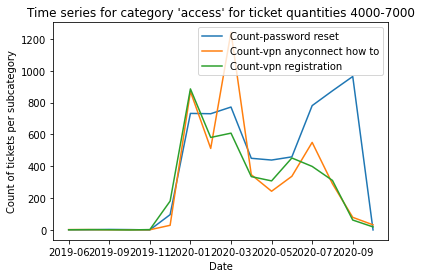

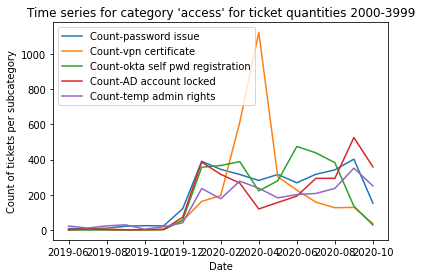

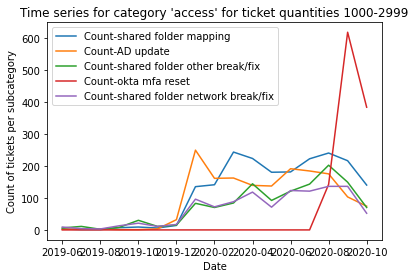

In [328]:
accessTimeSeries = pd.DataFrame(access_pwd_reset)
accessTimeSeries["Count-vpn anyconnect how to"] = access_vpn_anyconnect["Count-vpn anyconnect how to"]
accessTimeSeries['Count-vpn registration'] = access_vpn_registration['Count-vpn registration']
accessTimeSeries.plot(x='Date').set(title="Time series for category 'access' for ticket quantities 4000-7000", xlabel="Date", ylabel="Count of tickets per subcategory")
#print(accessTimeSeries)

accessTimeSeries2 = pd.DataFrame(access_password_issue)
accessTimeSeries2['Count-vpn certificate'] = access_vpn_certificate['Count-vpn certificate']
accessTimeSeries2['Count-okta self pwd registration'] = access_okta_registration['Count-okta self pwd registration']
accessTimeSeries2["Count-AD account locked"] = access_ADlocked["Count-AD account locked"]
accessTimeSeries2["Count-temp admin rights"] = access_admin_rights["Count-temp admin rights"]
accessTimeSeries2.plot(x='Date').set(title="Time series for category 'access' for ticket quantities 2000-3999", xlabel="Date", ylabel="Count of tickets per subcategory")
#print(accessTimeSeries2)

accessTimeSeries3 = pd.DataFrame(access_shared_folder_mapping)
accessTimeSeries3["Count-AD update"] = access_ADupdate["Count-AD update"]
accessTimeSeries3["Count-shared folder other break/fix"] = access_shared_folder_fix["Count-shared folder other break/fix"]
accessTimeSeries3['Count-okta mfa reset'] = access_okta_mfa_reset['Count-okta mfa reset']
accessTimeSeries3['Count-shared folder network break/fix'] = access_shared_folder_network_fix['Count-shared folder network break/fix']
accessTimeSeries3.plot(x='Date').set(title="Time series for category 'access' for ticket quantities 1000-2999", xlabel="Date", ylabel="Count of tickets per subcategory")
#print(accessTimeSeries3)

plt.show()

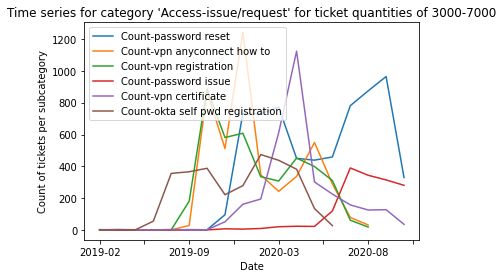

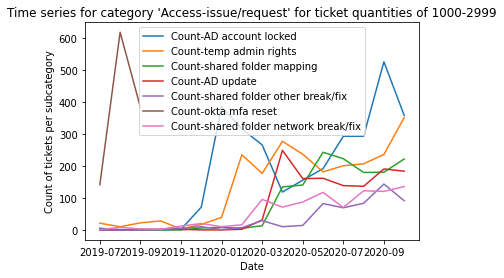

In [18]:
accessTimeSeries.plot(x='Date').set(title="Time series for category 'Access-issue/request' for ticket quantities of 3000-7000", xlabel="Date", ylabel="Count of tickets per subcategory")
accessTimeSeries2.plot(x='Date').set(title="Time series for category 'Access-issue/request' for ticket quantities of 1000-2999", xlabel="Date", ylabel="Count of tickets per subcategory")
plt.show()

In [93]:
# Category: 'software'
a_data_software = pd.DataFrame(a_data2.loc[a_data.category == 'software'])
a_data_software['subcategory'].value_counts()

software breakfix                  10450
software_other_install              2784
software request - how to           2337
appstore - request/how to            919
software_request_other_update        868
office 365 suite - break/fix         503
office  365 how to/install           503
microsoft teams how to               374
software_other_uninstall             321
software request                     243
microsoft teams breakfix             230
appstore - install failure           217
advantage - how to                   124
office 365 - license activation       58
software_other_previous_version       13
part_of_hsc_deployment_sw              1
Name: subcategory, dtype: int64

In [190]:
# Subcategory: software breakfix
software_breakfix = a_data_software[a_data_software.subcategory =='software breakfix']
software_breakfix = pd.DataFrame(software_breakfix.groupby([a_data_software['Date']])['subcategory'].count())
software_breakfix = software_breakfix[-19:]
software_breakfix.reset_index(inplace=True)
software_breakfix.columns = ["Date", "Count-software breakfix"]
#print(software_breakfix)

# Subcategory: software_other_install
software_other_install = a_data_software[a_data_software.subcategory =='software_other_install']
software_other_install = pd.DataFrame(software_other_install.groupby([a_data_software['Date']])['subcategory'].count())
software_other_install.reset_index(inplace=True)
software_other_install.columns = ["Date", "Count-software other install"]
software_other_install.loc[-1] = ['2019-05', 0] 
software_other_install.index = software_other_install.index + 1
software_other_install.loc[-1] = ['2019-04', 0] 
software_other_install.index = software_other_install.index + 1
software_other_install.loc[-1] = ['2019-07', 0] 
software_other_install.index = software_other_install.index + 1
software_other_install = software_other_install.reindex([1,2,3,0,4,5,6,7,8,9,10,11,12,13,14,15,16])
software_other_install.loc[17] = ['2020-09', 0] 
software_other_install.loc[18] = ['2020-10', 0] 
software_other_install.reset_index(inplace=True)
del software_other_install['index']
#print(software_other_install)

# Subcategory: software request - how to 
software_how_to = a_data_software[a_data_software.subcategory =='software request - how to']
software_how_to = pd.DataFrame(software_how_to.groupby([a_data_software['Date']])['subcategory'].count())
software_how_to.reset_index(inplace=True)
software_how_to.columns = ["Date", "Count-software request - how to"]
software_how_to.loc[-1] = ['2019-05', 0] 
software_how_to.index = software_how_to.index + 1
software_how_to.loc[-1] = ['2019-04', 0] 
software_how_to.index = software_how_to.index + 1
software_how_to.loc[-1] = ['2019-07', 0] 
software_how_to.index = software_how_to.index + 1
software_how_to = software_how_to.reindex([1,2,3,0,4,5,6,7,8,9,10,11,12,13,14,15,16])
software_how_to.loc[17] = ['2020-09', 0] 
software_how_to.loc[18] = ['2020-10', 0] 
software_how_to.reset_index(inplace=True)
del software_how_to['index']
#print(software_how_to)

# Subcategory: appstore - request/how to
software_appstore_how_to = a_data_software[a_data_software.subcategory =='appstore - request/how to']
software_appstore_how_to = pd.DataFrame(software_appstore_how_to.groupby([a_data_software['Date']])['subcategory'].count())
software_appstore_how_to.reset_index(inplace=True)
software_appstore_how_to.columns = ["Date", "Count-appstore how to"]
software_appstore_how_to.loc[-1] = ['2020-07', 0] 
software_appstore_how_to.index = software_appstore_how_to.index + 1
software_appstore_how_to.loc[-1] = ['2020-06', 0] 
software_appstore_how_to.index = software_appstore_how_to.index + 1
software_appstore_how_to.loc[-1] = ['2020-05', 0] 
software_appstore_how_to.index = software_appstore_how_to.index + 1
software_appstore_how_to.loc[-1] = ['2020-04', 0] 
software_appstore_how_to.index = software_appstore_how_to.index + 1
software_appstore_how_to.loc[-1] = ['2020-03', 0] 
software_appstore_how_to.index = software_appstore_how_to.index + 1
software_appstore_how_to.loc[-1] = ['2020-02', 0] 
software_appstore_how_to.index = software_appstore_how_to.index + 1
software_appstore_how_to.loc[-1] = ['2020-01', 0] 
software_appstore_how_to.index = software_appstore_how_to.index + 1
software_appstore_how_to.loc[-1] = ['2019-12', 0] 
software_appstore_how_to.index = software_appstore_how_to.index + 1
software_appstore_how_to.loc[-1] = ['2019-11', 0] 
software_appstore_how_to.index = software_appstore_how_to.index + 1
software_appstore_how_to.loc[-1] = ['2019-10', 0] 
software_appstore_how_to.index = software_appstore_how_to.index + 1
software_appstore_how_to.loc[-1] = ['2019-09', 0] 
software_appstore_how_to.index = software_appstore_how_to.index + 1
software_appstore_how_to.loc[-1] = ['2019-08', 0] 
software_appstore_how_to.index = software_appstore_how_to.index + 1
software_appstore_how_to.loc[-1] = ['2019-07', 0] 
software_appstore_how_to.index = software_appstore_how_to.index + 1
software_appstore_how_to.loc[-1] = ['2019-06', 0] 
software_appstore_how_to.index = software_appstore_how_to.index + 1
software_appstore_how_to.loc[-1] = ['2019-05', 0] 
software_appstore_how_to.index = software_appstore_how_to.index + 1
software_appstore_how_to.loc[-1] = ['2019-04', 0] 
software_appstore_how_to.index = software_appstore_how_to.index + 1
software_appstore_how_to = software_appstore_how_to.sort_index()
#print(software_appstore_how_to)

# Subcategory: software_request_other_update 
software_update = a_data_software[a_data_software.subcategory =='software_request_other_update']
software_update = pd.DataFrame(software_update.groupby([a_data_software['Date']])['subcategory'].count())
software_update.reset_index(inplace=True)
software_update.columns = ["Date", "Count-software request - update"]
software_update.loc[-1] = ['2019-04', 0] 
software_update.index = software_update.index + 1
software_update.loc[17] = ['2020-09', 0] 
software_update.loc[18] = ['2020-10', 0] 
software_update = software_update.sort_index()
#print(software_update)

# Subcategory: office  365 how to/install 
software_o365_install = a_data_software[a_data_software.subcategory =='office  365 how to/install']
software_o365_install = pd.DataFrame(software_o365_install.groupby([a_data_software['Date']])['subcategory'].count())
software_o365_install.reset_index(inplace=True)
software_o365_install.columns = ["Date", "Count-O365 install"]
software_o365_install.loc[-1] = ['2019-05', 0] 
software_o365_install.index = software_o365_install.index + 1
software_o365_install.loc[-1] = ['2019-04', 0] 
software_o365_install.index = software_o365_install.index + 1
software_o365_install.loc[-1] = ['2019-08', 0] 
software_o365_install.index = software_o365_install.index + 1
software_o365_install.loc[-1] = ['2019-10', 0] 
software_o365_install.index = software_o365_install.index + 1
software_o365_install = software_o365_install.reindex([2,3,4,5,1,6,0,7,8,9,10,11,12,13,14,15,16])
software_o365_install.loc[17] = ['2020-09', 0] 
software_o365_install.loc[18] = ['2020-10', 0] 
software_o365_install.reset_index(inplace=True)
del software_o365_install['index']
#print(software_o365_install)

# Subcategory: office 365 suite - break/fix  
software_o365_fix = a_data_software[a_data_software.subcategory =='office 365 suite - break/fix']
software_o365_fix = pd.DataFrame(software_o365_fix.groupby([a_data_software['Date']])['subcategory'].count())
software_o365_fix.reset_index(inplace=True)
software_o365_fix.columns = ["Date", "Count-O365 break fix"]
software_o365_fix.loc[-1] = ['2019-05', 0] 
software_o365_fix.index = software_o365_fix.index + 1
software_o365_fix = software_o365_fix.reindex([1,0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
software_o365_fix.loc[17] = ['2020-09', 0] 
software_o365_fix.loc[18] = ['2020-10', 0] 
software_o365_fix.reset_index(inplace=True)
del software_o365_fix['index']
#print(software_o365_fix)

In [192]:
# 2019-04 to 2020-10
#Subcategory: microsoft teams how to               374
teams_how_to = a_data_software[a_data_software.subcategory =='microsoft teams how to']
teams_how_to = pd.DataFrame(teams_how_to.groupby([a_data_software['Date']])['subcategory'].count())
teams_how_to.reset_index(inplace=True)
teams_how_to.columns = ["Date", "Count-Teams how-to"]
teams_how_to.loc[-1] = ['2019-08', 0] 
teams_how_to.index = teams_how_to.index + 1
teams_how_to.loc[-1] = ['2019-07', 0] 
teams_how_to.index = teams_how_to.index + 1
teams_how_to.loc[-1] = ['2019-06', 0] 
teams_how_to.index = teams_how_to.index + 1
teams_how_to.loc[-1] = ['2019-05', 0] 
teams_how_to.index = teams_how_to.index + 1
teams_how_to.loc[-1] = ['2019-04', 0] 
teams_how_to.index = teams_how_to.index + 1
teams_how_to.loc[17] = ['2020-09', 0] 
teams_how_to.loc[18] = ['2020-10', 0] 
teams_how_to = teams_how_to.sort_index()
#print(teams_how_to)

#Subcategory: software_other_uninstall             321
software_uninstall = a_data_software[a_data_software.subcategory =='software_other_uninstall']
software_uninstall = pd.DataFrame(software_uninstall.groupby([a_data_software['Date']])['subcategory'].count())
software_uninstall.reset_index(inplace=True)
software_uninstall.columns = ["Date", "Count-Software uninstall"]
software_uninstall.loc[-1] = ['2019-10', 0] 
software_uninstall.index = software_uninstall.index + 1
software_uninstall = software_uninstall.reindex([1,2,0,3,4,5,6,7,8,9,10,11,12,13,14])
software_uninstall.loc[13] = ['2020-09', 0] 
software_uninstall.loc[14] = ['2020-10', 0] 
software_uninstall.reset_index(inplace=True)
del software_uninstall['index']
software_uninstall.loc[-1] = ['2019-07', 0] 
software_uninstall.index = software_uninstall.index + 1
software_uninstall.loc[-1] = ['2019-06', 0] 
software_uninstall.index = software_uninstall.index + 1
software_uninstall.loc[-1] = ['2019-05', 0] 
software_uninstall.index = software_uninstall.index + 1
software_uninstall.loc[-1] = ['2019-04', 0] 
software_uninstall.index = software_uninstall.index + 1
software_uninstall = software_uninstall.sort_index()
#print(software_uninstall)

#Subcategory: software request                     243
software_request = a_data_software[a_data_software.subcategory =='software request']
software_request = pd.DataFrame(software_request.groupby([a_data_software['Date']])['subcategory'].count())
software_request.reset_index(inplace=True)
software_request.columns = ["Date", "Count-Software request"]
software_request.loc[-1] = ['2019-10', 0] 
software_request.index = software_request.index + 1
software_request = software_request.reindex([1,2,3,4,5,0,6,7,8,9,10,11,12,13,14])
software_request.loc[13] = ['2020-06', 0] 
software_request.loc[14] = ['2020-07', 0] 
software_request.loc[15] = ['2020-08', 0] 
software_request.loc[16] = ['2020-09', 0] 
software_request.loc[17] = ['2020-10', 0] 
software_request.reset_index(inplace=True)
del software_request['index']
software_request.loc[-1] = ['2019-04', 0] 
software_request.index = software_request.index + 1
software_request = software_request.sort_index()
#print(software_request)

#Subcategory: microsoft teams breakfix             230
teams_fix = a_data_software[a_data_software.subcategory =='microsoft teams breakfix']
teams_fix = pd.DataFrame(teams_fix.groupby([a_data_software['Date']])['subcategory'].count())
teams_fix.reset_index(inplace=True)
teams_fix.columns = ["Date", "Count-Teams breakfix"]
teams_fix.loc[-1] = ['2019-09', 0] 
teams_fix.index = teams_fix.index + 1
teams_fix.loc[-1] = ['2019-10', 0] 
teams_fix.index = teams_fix.index + 1
teams_fix.loc[-1] = ['2019-11', 0] 
teams_fix.index = teams_fix.index + 1
teams_fix.loc[-1] = ['2019-12', 0] 
teams_fix.index = teams_fix.index + 1
teams_fix = teams_fix.reindex([4,3,2,1,0,5,6,7,8,9])
teams_fix.loc[10] = ['2020-06', 0] 
teams_fix.loc[11] = ['2020-07', 0] 
teams_fix.loc[12] = ['2020-08', 0] 
teams_fix.loc[13] = ['2020-09', 0] 
teams_fix.loc[14] = ['2020-10', 0] 
teams_fix.reset_index(inplace=True)
del teams_fix['index']
teams_fix.loc[-1] = ['2019-07', 0] 
teams_fix.index = teams_fix.index + 1
teams_fix.loc[-1] = ['2019-06', 0] 
teams_fix.index = teams_fix.index + 1
teams_fix.loc[-1] = ['2019-05', 0] 
teams_fix.index = teams_fix.index + 1
teams_fix.loc[-1] = ['2019-04', 0] 
teams_fix.index = teams_fix.index + 1
teams_fix = teams_fix.sort_index()
#print(teams_fix)

#Subcategory: appstore - install failure           217
appstore_install_fail = a_data_software[a_data_software.subcategory =='appstore - install failure']
appstore_install_fail = pd.DataFrame(appstore_install_fail.groupby([a_data_software['Date']])['subcategory'].count())
appstore_install_fail.reset_index(inplace=True)
appstore_install_fail.columns = ["Date", "Count-appstore install fail"]
appstore_install_fail.loc[-1] = ['2020-06', 0] 
appstore_install_fail.index = appstore_install_fail.index + 1
appstore_install_fail.loc[-1] = ['2020-05', 0] 
appstore_install_fail.index = appstore_install_fail.index + 1
appstore_install_fail.loc[-1] = ['2020-04', 0] 
appstore_install_fail.index = appstore_install_fail.index + 1
appstore_install_fail.loc[-1] = ['2020-03', 0] 
appstore_install_fail.index = appstore_install_fail.index + 1
appstore_install_fail.loc[-1] = ['2020-02', 0] 
appstore_install_fail.index = appstore_install_fail.index + 1
appstore_install_fail.loc[-1] = ['2020-01', 0] 
appstore_install_fail.index = appstore_install_fail.index + 1
appstore_install_fail.loc[-1] = ['2019-12', 0] 
appstore_install_fail.index = appstore_install_fail.index + 1
appstore_install_fail.loc[-1] = ['2019-11', 0] 
appstore_install_fail.index = appstore_install_fail.index + 1
appstore_install_fail.loc[-1] = ['2019-10', 0] 
appstore_install_fail.index = appstore_install_fail.index + 1
appstore_install_fail.loc[-1] = ['2019-09', 0] 
appstore_install_fail.index = appstore_install_fail.index + 1
appstore_install_fail.loc[-1] = ['2019-08', 0] 
appstore_install_fail.index = appstore_install_fail.index + 1
appstore_install_fail.loc[-1] = ['2019-07', 0] 
appstore_install_fail.index = appstore_install_fail.index + 1
appstore_install_fail.loc[-1] = ['2019-06', 0] 
appstore_install_fail.index = appstore_install_fail.index + 1
appstore_install_fail.loc[-1] = ['2019-05', 0] 
appstore_install_fail.index = appstore_install_fail.index + 1
appstore_install_fail.loc[-1] = ['2019-04', 0] 
appstore_install_fail.index = appstore_install_fail.index + 1
appstore_install_fail = appstore_install_fail.sort_index()
#print(appstore_install_fail)

#Subcategory: advantage - how to                   124
advantage_how_to = a_data_software[a_data_software.subcategory =='advantage - how to']
advantage_how_to = pd.DataFrame(advantage_how_to.groupby([a_data_software['Date']])['subcategory'].count())
advantage_how_to.reset_index(inplace=True)
advantage_how_to.columns = ["Date", "Count-advantage how-to"]
advantage_how_to.loc[-1] = ['2020-07', 0] 
advantage_how_to.index = advantage_how_to.index + 1
advantage_how_to.loc[-1] = ['2020-06', 0] 
advantage_how_to.index = advantage_how_to.index + 1
advantage_how_to.loc[-1] = ['2020-05', 0] 
advantage_how_to.index = advantage_how_to.index + 1
advantage_how_to.loc[-1] = ['2020-04', 0] 
advantage_how_to.index = advantage_how_to.index + 1
advantage_how_to.loc[-1] = ['2020-03', 0] 
advantage_how_to.index = advantage_how_to.index + 1
advantage_how_to = advantage_how_to.reindex([5,0,1,2,3,4,6,7,8])
advantage_how_to.reset_index(inplace=True)
del advantage_how_to['index']
advantage_how_to.loc[-1] = ['2019-12', 0] 
advantage_how_to.index = advantage_how_to.index + 1
advantage_how_to.loc[-1] = ['2019-11', 0] 
advantage_how_to.index = advantage_how_to.index + 1
advantage_how_to.loc[-1] = ['2019-10', 0] 
advantage_how_to.index = advantage_how_to.index + 1
advantage_how_to.loc[-1] = ['2019-09', 0] 
advantage_how_to.index = advantage_how_to.index + 1
advantage_how_to.loc[-1] = ['2019-08', 0] 
advantage_how_to.index = advantage_how_to.index + 1
advantage_how_to.loc[-1] = ['2019-07', 0] 
advantage_how_to.index = advantage_how_to.index + 1
advantage_how_to.loc[-1] = ['2019-06', 0] 
advantage_how_to.index = advantage_how_to.index + 1
advantage_how_to.loc[-1] = ['2019-05', 0] 
advantage_how_to.index = advantage_how_to.index + 1
advantage_how_to.loc[-1] = ['2019-04', 0] 
advantage_how_to.index = advantage_how_to.index + 1
advantage_how_to = advantage_how_to.sort_index()
#print(advantage_how_to)


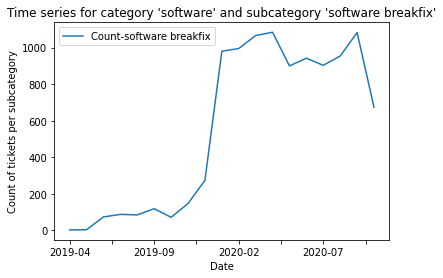

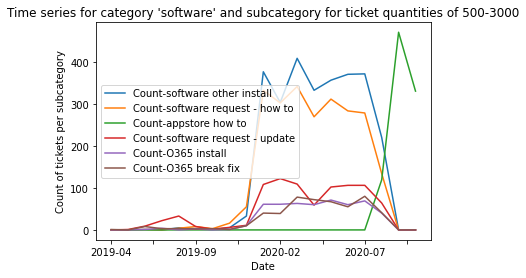

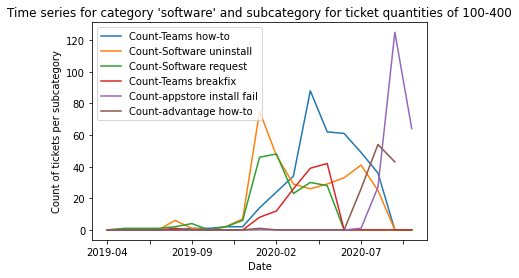

In [193]:
softwareTimeSeries = pd.DataFrame(software_breakfix)
softwareTimeSeries.plot(x='Date').set(title="Time series for category 'software' and subcategory 'software breakfix'", xlabel="Date", ylabel="Count of tickets per subcategory")

softwareTimeSeries2 = pd.DataFrame(software_other_install)
softwareTimeSeries2['Count-software request - how to'] = software_how_to['Count-software request - how to']
softwareTimeSeries2['Count-appstore how to'] = software_appstore_how_to['Count-appstore how to']
softwareTimeSeries2['Count-software request - update'] = software_update['Count-software request - update']
softwareTimeSeries2['Count-O365 install'] = software_o365_install['Count-O365 install']
softwareTimeSeries2['Count-O365 break fix'] = software_o365_fix['Count-O365 break fix']
softwareTimeSeries2.plot(x='Date').set(title="Time series for category 'software' and subcategory for ticket quantities of 500-3000", xlabel="Date", ylabel="Count of tickets per subcategory")

softwareTimeSeries3 =pd.DataFrame(teams_how_to)
softwareTimeSeries3["Count-Software uninstall"] = software_uninstall["Count-Software uninstall"]
softwareTimeSeries3["Count-Software request"] = software_request["Count-Software request"]
softwareTimeSeries3["Count-Teams breakfix"] = teams_fix["Count-Teams breakfix"]
softwareTimeSeries3["Count-appstore install fail"] = appstore_install_fail["Count-appstore install fail"]
softwareTimeSeries3["Count-advantage how-to"] = advantage_how_to["Count-advantage how-to"]
softwareTimeSeries3.plot(x='Date').set(title="Time series for category 'software' and subcategory for ticket quantities of 100-400", xlabel="Date", ylabel="Count of tickets per subcategory")

plt.show()

In [10]:
# Category: 'application-issue/request'
a_data_application_issue = pd.DataFrame(a_data2.loc[a_data.category == 'application-issue/request'])
a_data_application_issue['subcategory'].value_counts()

oracle - password reset                          2821
all other issues                                 1778
workday/myhr referral                            1009
ecosystem - request for info                      958
oracle - request for info                         849
oracle - other issue                              755
workday - break/fix                               372
oracle other issue/request                        363
aecom university                                  336
apic - break/fix                                  282
ecosystem - other issue                           281
ecosystem - request instruction                   270
citrix / vdi - request for info                   232
citrix / vdi - other issue                        192
office 365 suite - break/fix                      170
aecom university - break /fix                     160
office  365 how to/install                        158
citrix desktop - break / fix                      154
ms teams - install/configura

In [11]:
# Subcategory: oracle - password reset                          2821
application_oracle_pwd_reset = a_data_application_issue[a_data_application_issue.subcategory =='oracle - password reset']
application_oracle_pwd_reset = pd.DataFrame(application_oracle_pwd_reset.groupby([a_data_application_issue['Date']])['subcategory'].count())
application_oracle_pwd_reset.reset_index(inplace=True)
application_oracle_pwd_reset.columns = ["Date", "Count - oracle password reset"]
application_oracle_pwd_reset.loc[-1] = ['2019-11', 0] 
application_oracle_pwd_reset.index = application_oracle_pwd_reset.index + 1
application_oracle_pwd_reset.loc[-1] = ['2019-10', 0] 
application_oracle_pwd_reset.index = application_oracle_pwd_reset.index + 1
application_oracle_pwd_reset.loc[-1] = ['2019-09', 0] 
application_oracle_pwd_reset.index = application_oracle_pwd_reset.index + 1
application_oracle_pwd_reset.loc[-1] = ['2019-08', 0] 
application_oracle_pwd_reset.index = application_oracle_pwd_reset.index + 1
application_oracle_pwd_reset.loc[-1] = ['2019-07', 0] 
application_oracle_pwd_reset.index = application_oracle_pwd_reset.index + 1
application_oracle_pwd_reset = application_oracle_pwd_reset.sort_index()
#print(application_oracle_pwd_reset)

# Subcategory: all other issues                                 1778
application_other = a_data_application_issue[a_data_application_issue.subcategory =='all other issues']
application_other = pd.DataFrame(application_other.groupby([a_data_application_issue['Date']])['subcategory'].count())
application_other.reset_index(inplace=True)
application_other.columns = ["Date", "Count - other issues"]
application_other = application_other[-16:]
application_other.reset_index(inplace=True)
del application_other['index']
#print(application_other)

# Subcategory: workday/myhr referral                            1009
application_referral = a_data_application_issue[a_data_application_issue.subcategory =='workday/myhr referral']
application_referral = pd.DataFrame(application_referral.groupby([a_data_application_issue['Date']])['subcategory'].count())
application_referral.reset_index(inplace=True)
application_referral.columns = ["Date", "Count - referral"]
application_referral.loc[-1] = ['2019-08', 0] 
application_referral.index = application_referral.index + 1
application_referral = application_referral.reindex([1,0,2,3,4,5,6,7,8,9,10,11,12,13,14])
application_referral.reset_index(inplace=True)
del application_referral['index']
#print(application_referral)

# Subcategory: ecosystem - request for info                      958
application_ecosystem = a_data_application_issue[a_data_application_issue.subcategory =='ecosystem - request for info']
application_ecosystem = pd.DataFrame(application_ecosystem.groupby([a_data_application_issue['Date']])['subcategory'].count())
application_ecosystem.reset_index(inplace=True)
application_ecosystem.columns = ["Date", "Count - ecosystem request"]
application_ecosystem.loc[-1] = ['2019-10', 0] 
application_ecosystem.index = application_ecosystem.index + 1
application_ecosystem.loc[-1] = ['2019-09', 0] 
application_ecosystem.index = application_ecosystem.index + 1
application_ecosystem.loc[-1] = ['2019-08', 0] 
application_ecosystem.index = application_ecosystem.index + 1
application_ecosystem = application_ecosystem.reindex([3,0,1,2,4,5,6,7,8,9,10,11,12,13,14,15])
application_ecosystem.reset_index(inplace=True)
del application_ecosystem['index']
#print(application_ecosystem)

# Subcategory: oracle - request for info                         849
application_oracle_request = a_data_application_issue[a_data_application_issue.subcategory =='oracle - request for info']
application_oracle_request = pd.DataFrame(application_oracle_request.groupby([a_data_application_issue['Date']])['subcategory'].count())
application_oracle_request.reset_index(inplace=True)
application_oracle_request.columns = ["Date", "Count - Oracle request for info"]
application_oracle_request.loc[-1] = ['2019-09', 0] 
application_oracle_request.index = application_oracle_request.index + 1
application_oracle_request.loc[-1] = ['2019-08', 0] 
application_oracle_request.index = application_oracle_request.index + 1
application_oracle_request = application_oracle_request.reindex([2,0,1,3,4,5,6,7,8,9,10,11,12,13,14,15])
application_oracle_request.reset_index(inplace=True)
del application_oracle_request['index']
#print(application_oracle_request)

# Subcategory: oracle - other issue                              755
oracle_other = a_data_application_issue[a_data_application_issue.subcategory =='oracle - other issue']
oracle_other = pd.DataFrame(oracle_other.groupby([a_data_application_issue['Date']])['subcategory'].count())
oracle_other.reset_index(inplace=True)
oracle_other.columns = ["Date", "Count - oracle other"]
oracle_other.loc[-1] = ['2019-09', 0] 
oracle_other.index = oracle_other.index + 1
oracle_other = oracle_other.reindex([1,2,0,3,4,5,6,7,8,9,10,11,12,13])
oracle_other.reset_index(inplace=True)
del oracle_other['index']
#print(oracle_other)

'''
workday - break/fix                               372
oracle other issue/request                        363
aecom university                                  336
apic - break/fix                                  282
ecosystem - other issue                           281
ecosystem - request instruction                   270
citrix / vdi - request for info                   232
citrix / vdi - other issue                        192
office 365 suite - break/fix                      170
aecom university - break /fix                     160
office  365 how to/install                        158
citrix desktop - break / fix                      154
ms teams - install/configuration                  101
'''

'\nworkday - break/fix                               372\noracle other issue/request                        363\naecom university                                  336\napic - break/fix                                  282\necosystem - other issue                           281\necosystem - request instruction                   270\ncitrix / vdi - request for info                   232\ncitrix / vdi - other issue                        192\noffice 365 suite - break/fix                      170\naecom university - break /fix                     160\noffice  365 how to/install                        158\ncitrix desktop - break / fix                      154\nms teams - install/configuration                  101\n'

       Date  ...  Count oracle other
0   2019-07  ...                 1.0
1   2019-08  ...                 4.0
2   2019-09  ...                 0.0
3   2019-10  ...                 4.0
4   2019-11  ...                 7.0
5   2019-12  ...                39.0
6   2020-01  ...                83.0
7   2020-02  ...                84.0
8   2020-03  ...                98.0
9   2020-04  ...                67.0
10  2020-05  ...                78.0
11  2020-06  ...               109.0
12  2020-07  ...               124.0
13  2020-08  ...                57.0
14  2020-09  ...                 NaN
15  2020-10  ...                 NaN

[16 rows x 4 columns]


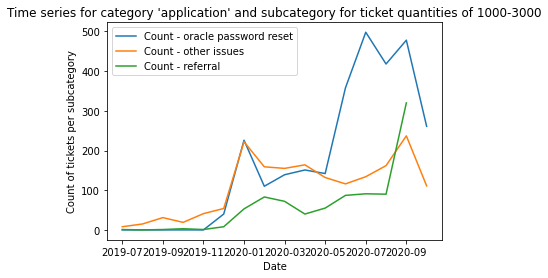

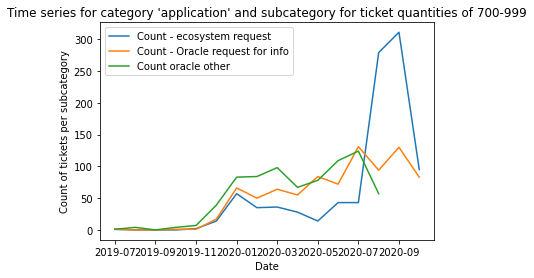

In [13]:
applicationTimeSeries = pd.DataFrame(application_oracle_pwd_reset)
applicationTimeSeries['Count - other issues'] = application_other['Count - other issues']
applicationTimeSeries['Count - referral'] = application_referral['Count - referral']
applicationTimeSeries.plot(x='Date').set(title="Time series for category 'application' and subcategory for ticket quantities of 1000-3000", xlabel="Date", ylabel="Count of tickets per subcategory")

applicationTimeSeries2 = pd.DataFrame(application_ecosystem)
applicationTimeSeries2['Count - Oracle request for info'] = application_oracle_request['Count - Oracle request for info']
applicationTimeSeries2['Count oracle other'] = oracle_other['Count - oracle other']
print(applicationTimeSeries2)

applicationTimeSeries2.plot(x='Date').set(title="Time series for category 'application' and subcategory for ticket quantities of 700-999", xlabel="Date", ylabel="Count of tickets per subcategory")

plt.show()

In [203]:
# Category: 'email'
a_data_email = pd.DataFrame(a_data2.loc[a_data.category == 'email'])
a_data_email['subcategory'].value_counts()

email-break / fix                          2121
email - how to                             1351
email - setup                               397
email - configuration                       279
email-access                                163
email-shared mailbox / calendar request      83
email - data folder                          66
email-public folder                          18
email - global address list                  10
email - proofpoint - break/fix                7
email - proofpoint                            1
mobile-break / fix                            1
Name: subcategory, dtype: int64

In [234]:
# Subcategory: email-break / fix                          2121
email_fix = a_data_email[a_data_email.subcategory =='email-break / fix']
email_fix = pd.DataFrame(email_fix.groupby([a_data_email['Date']])['subcategory'].count())
email_fix.reset_index(inplace=True)
email_fix.columns = ["Date", "Count - email break fix"]
#print(email_fix)

# Subcategory: email - how to                             1351
email_how = a_data_email[a_data_email.subcategory =='email - how to']
email_how = pd.DataFrame(email_how.groupby([a_data_email['Date']])['subcategory'].count())
email_how.reset_index(inplace=True)
email_how.columns = ["Date", "Count - email how-to"]
email_how.loc[-1] = ['2019-10', 0] 
email_how.index = email_how.index + 1
email_how = email_how.reindex([1,2,3,4,0,5,6,7,8,9,10,11,12,13,14,15,16,17])
email_how.reset_index(inplace=True)
del email_how['index']
email_how.loc[-1] = ['2019-05', 0] 
email_how.index = email_how.index + 1
email_how.loc[-1] = ['2019-03', 0] 
email_how.index = email_how.index + 1
email_how = email_how.sort_index()
#print(email_how)


# Subcategory: email - setup                               397
email_setup = a_data_email[a_data_email.subcategory =='email - setup']
email_setup = pd.DataFrame(email_setup.groupby([a_data_email['Date']])['subcategory'].count())
email_setup.reset_index(inplace=True)
email_setup.columns = ["Date", "Count - email setup"]
email_setup.loc[-1] = ['2019-09', 0] 
email_setup.index = email_setup.index + 1
email_setup = email_setup.reindex([1,2,3,0,4,5,6,7,8,9,10,11,12,13,14,15,16])
email_setup.reset_index(inplace=True)
del email_setup['index']
#print(email_setup)

# Subcategory: email - configuration                       279
email_configuration = a_data_email[a_data_email.subcategory =='email - configuration']
email_configuration = pd.DataFrame(email_configuration.groupby([a_data_email['Date']])['subcategory'].count())
email_configuration.reset_index(inplace=True)
email_configuration.columns = ["Date", "Count - email configuration"]
email_configuration.loc[-1] = ['2019-10', 0] 
email_configuration.index = email_configuration.index + 1
email_configuration = email_configuration.reindex([1,2,3,0,4,5,6,7,8,9,10,11,12,13,14,15])
email_configuration.reset_index(inplace=True)
del email_configuration['index']
email_configuration.loc[-1] = ['2019-06', 0] 
email_configuration.index = email_configuration.index + 1
email_configuration = email_configuration.sort_index()
#print(email_configuration)

# Subcategory: email-access                                163
email_access = a_data_email[a_data_email.subcategory =='email-access']
email_access = pd.DataFrame(email_access.groupby([a_data_email['Date']])['subcategory'].count())
email_access.reset_index(inplace=True)
email_access.columns = ["Date", "Count - email access"]
email_access.loc[-1] = ['2019-08', 0] 
email_access.index = email_access.index + 1
email_access = email_access.reindex([1,2,3,0,4,5,6,7,8,9,10,11,12,13,14,15,16,17])
email_access.reset_index(inplace=True)
del email_access['index']
email_access = email_access[-17:]
#print(email_access)

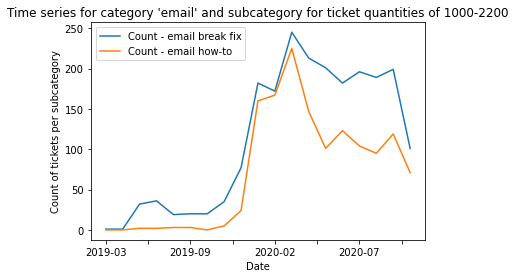

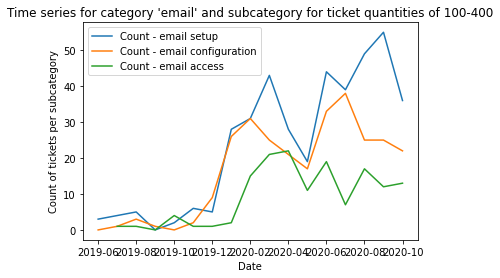

In [235]:
emailTimeSeries = pd.DataFrame(email_fix)
emailTimeSeries['Count - email how-to'] = email_how['Count - email how-to']
emailTimeSeries.plot(x='Date').set(title="Time series for category 'email' and subcategory for ticket quantities of 1000-2200", xlabel="Date", ylabel="Count of tickets per subcategory")

emailTimeSeries2 = pd.DataFrame(email_setup)
emailTimeSeries2['Count - email configuration'] = email_configuration['Count - email configuration']
emailTimeSeries2['Count - email access'] = email_access['Count - email access']
emailTimeSeries2.plot(x='Date').set(title="Time series for category 'email' and subcategory for ticket quantities of 100-400", xlabel="Date", ylabel="Count of tickets per subcategory")

plt.show()

In [195]:
# Category: 'computer hardware'
a_data_computer_hardware = pd.DataFrame(a_data2.loc[a_data.category == 'computer hardware'])
a_data_computer_hardware['subcategory'].value_counts()

computer break / fix      4120
other                      611
computer return             91
computer lost / stolen      17
part_of_hsc_deployment      10
other-issue / error          1
Name: subcategory, dtype: int64

In [200]:
# Subcategory: computer break / fix
computer_hardware_fix = a_data_computer_hardware[a_data_computer_hardware.subcategory =='computer break / fix']
computer_hardware_fix = pd.DataFrame(computer_hardware_fix.groupby([a_data_computer_hardware['Date']])['subcategory'].count())
computer_hardware_fix.reset_index(inplace=True)
computer_hardware_fix.columns = ["Date", "Count - hardware break fix"]
computer_hardware_fix = computer_hardware_fix[-18:]
#print(computer_hardware_fix)

# Subcategory: other
hardware_other = a_data_computer_hardware[a_data_computer_hardware.subcategory =='other']
hardware_other = pd.DataFrame(hardware_other.groupby([a_data_computer_hardware['Date']])['subcategory'].count())
hardware_other.reset_index(inplace=True)
hardware_other.columns = ["Date", "Count - hardware other"]
#print(hardware_other)

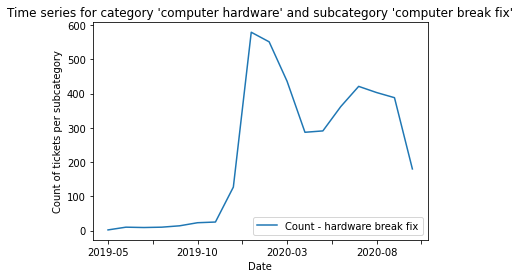

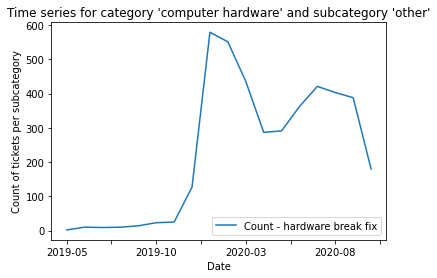

In [201]:
hardwareTimeSeries = pd.DataFrame(computer_hardware_fix)
hardwareTimeSeries.plot(x='Date').set(title="Time series for category 'computer hardware' and subcategory 'computer break fix'", xlabel="Date", ylabel="Count of tickets per subcategory")

hardwareTimeSeries2 = pd.DataFrame(hardware_other)
hardwareTimeSeries.plot(x='Date').set(title="Time series for category 'computer hardware' and subcategory 'other'", xlabel="Date", ylabel="Count of tickets per subcategory")

plt.show()

# COMPANY J - EDA

In [ ]:
'''
Company J
selcat = ['Desktop or laptop', 'Access and passwords', 'Application support', 'Infrastructure services', 'Easy connect', 'Telephone & Conference (Audio, Video)']
'''

In [14]:
j_data = pd.read_csv('/content/gdrive/Shared drives/IST 718 Project/j_cleaned.csv')
#j_data['category'] =  j_data['u_actual_category'].astype(str)
#j_data['subcategory'] =  j_data['u_actual_subcategory'].astype(str)
j_data['opened_at'] = pd.to_datetime(j_data.opened_at)
j_data['Date'] = j_data['opened_at'].dt.strftime('%Y-%m')
#print(j_data.columns)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,5,7,9,10,12,14,17,18,19,24,28,29,30,32,34,35,37,38,39,41,42,44,52,53,54,55,56,57,58,59,64,66,67,68,69,71,72,73,74,75,76,77,85) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
j_data['category'].value_counts()
#print(j_data.columns)

Desktop or laptop                        3476
Access and passwords                     2166
Application support                      2039
Infrastructure services                   577
Printers and peripherals                  474
Mobility devices and services             454
Easy connect                              310
Software                                  257
Email / Calendar                          109
Telephone & Conference (Audio, Video)      78
Collaboration and content tools            64
Microsoft Skype services                   27
ININ (Contact Center service)               7
Infrastructure Monitoring                   5
Engineering                                 2
Customer Success Business Management        2
Finance                                     1
Name: category, dtype: int64

In [16]:
j_data2 = j_data.drop(['Unnamed: 0', 'number', 'opened_at', 'incident_state', 'sys_updated_by',
       'category', 'short_description', 'caller_id.location',
       'assignment_group', 'u_time_last_workgroup_first_se',
       'u_resolution_rejected_report', 'u_resolution_rejected',
       'u_rejected_from_assignedto', 'u_reject_count', 'u_last_transfer_time',
       'u_last_incident_state', 'u_last_assignment_group',
       'u_initial_support_group', 'u_initial_priority', 'u_incident_rejected',
       'urgency', 'sys_mod_count', 'sys_updated_on', 'time_worked',
       'u_time_resolved', 'sys_class_name', 'u_task_state', 'state',
       'severity', 'priority', 'u_pending_reminder_sent',
       'u_pending_user_last_workgroup_', 'u_operational_task',
       'u_notify_caller_update', 'notify', 'u_new_requirement', 'made_sla',
       'u_last_service_call_update', 'u_last_priority',
       'u_last_assignment_time', 'impact', 'u_incnumber', 'u_escalation_level',
       'escalation', 'u_enhancement', 'cal_dur_num', 'knowledge', 'sys_domain',
       'sla_due', 'sys_created_by', 'sys_created_on', 'contact_type',
       'u_contact_windows_team', 'u_contact_unix_team',
       'u_contact_unified_messaging_te', 'u_contact_network_team',
       'u_contact_foundation_team', 'u_contact_dba_team',
       'u_contact_client_technology_gr', 'u_close_code', 'bus_dur_num',
       'activity_due', 'active', 'assigned_to',
       'reassignment_count', 'expected_start', 'parent', 'due_date',
       'closed_by', 'closed_at', 'work_end', 'request_item', 'request',
       'TicketDuration', 'ExpectedTaskDuration', 'TaskDuration',
       'CloseWorkDiff', 'TotalSlaDuration', 'ULastWorkgroupDuration',
       'TimeFirstTransfer', 'PendingUserDuration', 'Pending3rdPartyDuration',
       'CalendarDuration', 'BusinessDuration',
       'last_service_call_update_datetime'], axis=1)
#print(j_data2)

In [17]:
# Category: Desktop or laptop
j_data_desktop = pd.DataFrame(j_data2.loc[j_data.category == 'Desktop or laptop'])
j_data_desktop['subcategory'].value_counts()

desktop / laptop hardware issue          1660
desktop / laptop application issue        928
other                                     296
operating system issue                    288
malware / virus infection                 123
vpn client issue                          123
backup / restore issue                     24
printing issue                             21
device encryption                           7
workstation issue                           3
problem with access to an application       1
server                                      1
change or reset password                    1
Name: subcategory, dtype: int64

In [8]:
# Subcategory: desktop / laptop hardware issue
hardware_issue = j_data_desktop[j_data_desktop.subcategory =='desktop / laptop hardware issue']
hardware_issue = pd.DataFrame(hardware_issue.groupby([j_data_desktop['Date']])['subcategory'].count())
hardware_issue.reset_index(inplace=True)
hardware_issue.columns = ["Date", "Count - hardware issue"]
#print(hardware_issue)

# Subcategory: desktop / laptop application issue
app_issue = j_data_desktop[j_data_desktop.subcategory =='desktop / laptop application issue']
app_issue = pd.DataFrame(app_issue.groupby([j_data_desktop['Date']])['subcategory'].count())
app_issue.reset_index(inplace=True)
app_issue.columns = ["Date", "Count - application issue"]
#print(app_issue)

# Subcategory: other
other = j_data_desktop[j_data_desktop.subcategory =='other']
other = pd.DataFrame(other.groupby([j_data_desktop['Date']])['subcategory'].count())
other.reset_index(inplace=True)
other.columns = ["Date", "Count - other"]
other.loc[-1] = ['2019-09', 0] 
other.index = other.index + 1
other = other.reindex([0,1,2,3,4,5,6,7,8,9,10,11,12,13])
other.reset_index(inplace=True)
del other['index']
#print(other)

# Subcategory: operating system issue
operating_system = j_data_desktop[j_data_desktop.subcategory =='operating system issue']
operating_system = pd.DataFrame(operating_system.groupby([j_data_desktop['Date']])['subcategory'].count())
operating_system.reset_index(inplace=True)
operating_system.columns = ["Date", "Count - operating system issue"]
#print(operating_system)

# Subcategory: malware / virus infection
virus = j_data_desktop[j_data_desktop.subcategory =='malware / virus infection']
virus = pd.DataFrame(virus.groupby([j_data_desktop['Date']])['subcategory'].count())
virus.reset_index(inplace=True)
virus.columns = ["Date", "Count - virus"]
virus.loc[-1] = ['2019-11', 0] 
virus.index = virus.index + 1
virus.loc[-1] = ['2020-01', 0] 
virus.index = virus.index + 1
virus.loc[-1] = ['2019-09', 0] 
virus.index = virus.index + 1
virus = virus.reindex([0,3,2,4,1,5,6,7,8,9,10,11,12,13])
virus.reset_index(inplace=True)
del virus['index']
#print(virus)

# Subcategory: vpn client issue
vpn_client_issue = j_data_desktop[j_data_desktop.subcategory =='vpn client issue']
vpn_client_issue = pd.DataFrame(vpn_client_issue.groupby([j_data_desktop['Date']])['subcategory'].count())
vpn_client_issue.reset_index(inplace=True)
vpn_client_issue.columns = ["Date", "Count - vpn client issue"]
vpn_client_issue.loc[-1] = ['2019-09', 0] 
vpn_client_issue.index = vpn_client_issue.index + 1
vpn_client_issue = vpn_client_issue.reindex([0,1,2,3,4,5,6,7,8,9,10,11,12,13])
vpn_client_issue.reset_index(inplace=True)
del vpn_client_issue['index']
#print(vpn_client_issue)


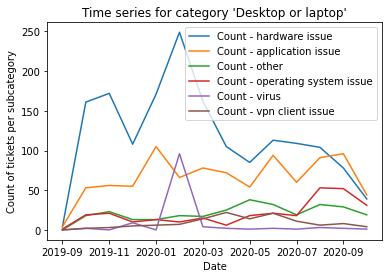

In [10]:
desktopTimeSeries = pd.DataFrame(hardware_issue)
desktopTimeSeries["Count - application issue"] = app_issue["Count - application issue"]
desktopTimeSeries['Count - other'] = other["Count - other"]
desktopTimeSeries["Count - operating system issue"] = operating_system["Count - operating system issue"]
desktopTimeSeries["Count - virus"] = virus["Count - virus"]
desktopTimeSeries["Count - vpn client issue"] = vpn_client_issue["Count - vpn client issue"]
#print(desktopTimeSeries)

desktopTimeSeries.plot(x='Date').set(title="Time series for category 'Desktop or laptop'", xlabel="Date", ylabel="Count of tickets per subcategory")
#plt.axvline(x='Date', color="red", linestyle="--") 

#for x in desktopTimeSeries['Date']:
#    plt.axvline(x, color='red', linestyle='--')

plt.show()

In [ ]:
# Category: Access and passwords
j_data_access_pwd = pd.DataFrame(j_data2.loc[j_data.category == 'Access and passwords'])
j_data_access_pwd['subcategory'].value_counts()

change or reset password                 826
problem with remote access/vpn/token     653
problem with access to an application    312
wireless access                          147
internet access                           75
wired connection                          74
request access to an application          72
access to server / fileserver              7
Name: subcategory, dtype: int64

In [401]:
# Subcategory: change or reset password
change_pwd = j_data_access_pwd[j_data_access_pwd.subcategory =='change or reset password']
change_pwd = pd.DataFrame(change_pwd.groupby([j_data_access_pwd['Date']])['subcategory'].count())
change_pwd.reset_index(inplace=True)
change_pwd.columns = ["Date", "Count - change or reset password"]
change_pwd.loc[-1] = ['2019-09', 0] 
change_pwd.index = change_pwd.index + 1
change_pwd = change_pwd.reindex([0,1,2,3,4,5,6,7,8,9,10,11,12,13])
change_pwd.reset_index(inplace=True)
del change_pwd['index']
#print(change_pwd)

# Subcategory: problem with remote access/vpn/token
remote_access = j_data_access_pwd[j_data_access_pwd.subcategory =='problem with remote access/vpn/token']
remote_access = pd.DataFrame(remote_access.groupby([j_data_access_pwd['Date']])['subcategory'].count())
remote_access.reset_index(inplace=True)
remote_access.columns = ["Date", "Count - problem with remote access"]
#print(remote_access)

# Subcategory: problem with access to an application
app_access = j_data_access_pwd[j_data_access_pwd.subcategory =='problem with access to an application']
app_access = pd.DataFrame(app_access.groupby([j_data_access_pwd['Date']])['subcategory'].count())
app_access.reset_index(inplace=True)
app_access.columns = ["Date", "Count - problem app access"]
app_access.loc[-1] = ['2019-09', 0] 
app_access.index = app_access.index + 1
app_access = app_access.reindex([0,1,2,3,4,5,6,7,8,9,10,11,12,13])
app_access.reset_index(inplace=True)
del app_access['index']
#print(app_access)

# Subcategory: wireless access
wireless_access = j_data_access_pwd[j_data_access_pwd.subcategory =='wireless access']
wireless_access = pd.DataFrame(wireless_access.groupby([j_data_access_pwd['Date']])['subcategory'].count())
wireless_access.reset_index(inplace=True)
wireless_access.columns = ["Date", "Count - wireless access"]
#print(wireless_access)

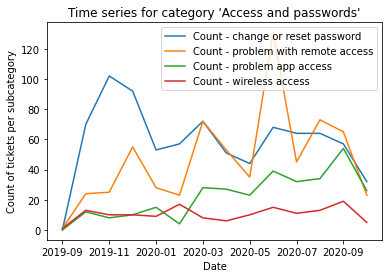

In [402]:
accessPassTimeSeries = pd.DataFrame(change_pwd)
accessPassTimeSeries['Count - problem with remote access'] = remote_access['Count - problem with remote access']
accessPassTimeSeries['Count - problem app access'] = app_access["Count - problem app access"]
accessPassTimeSeries["Count - wireless access"] = wireless_access["Count - wireless access"]
#print(accessPassTimeSeries)
accessPassTimeSeries.plot(x='Date').set(title="Time series for category 'Access and passwords'", xlabel="Date", ylabel="Count of tickets per subcategory")
plt.show()

In [18]:
# Category: Application support
j_data_app_support = pd.DataFrame(j_data2.loc[j_data.category == 'Application support'])
j_data_app_support['subcategory'].value_counts()

report an issue                1615
ask question (how do iâ¦?)     152
provide access                  127
other                            96
enhance application              29
fix data                         19
run report/extract data           1
Name: subcategory, dtype: int64

In [19]:
# Subcategory: report an issue
report_an_issue = j_data_app_support[j_data_app_support.subcategory =='report an issue']
report_an_issue = pd.DataFrame(report_an_issue.groupby([j_data_app_support['Date']])['subcategory'].count())
report_an_issue.reset_index(inplace=True)
report_an_issue.columns = ["Date", "Count - report an issue"]
#print(report_an_issue)

# Subcategory: ask question (how do iâ¦?)
ask_question = j_data_app_support[j_data_app_support.subcategory =='ask question (how do iâ¦?)']
ask_question = pd.DataFrame(ask_question.groupby([j_data_app_support['Date']])['subcategory'].count())
ask_question.reset_index(inplace=True)
ask_question.columns = ["Date", "Count - ask question"]
ask_question.loc[-1] = ['2019-09', 0] 
ask_question.index = ask_question.index + 1
ask_question = ask_question.reindex([1,0,2,3,4,5,6,7,8,9,10,11,12,13,14])
ask_question.reset_index(inplace=True)
del ask_question['index']
#print(ask_question)

# Subcategory: provide access
provide_access = j_data_app_support[j_data_app_support.subcategory =='provide access']
provide_access = pd.DataFrame(provide_access.groupby([j_data_app_support['Date']])['subcategory'].count())
provide_access.reset_index(inplace=True)
provide_access.columns = ["Date", "Count - provide access"]
provide_access.loc[-1] = ['2019-08', 0] 
provide_access.index = provide_access.index + 1
provide_access.loc[-1] = ['2019-09', 0] 
provide_access.index = provide_access.index + 1
provide_access = provide_access.reindex([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
provide_access.reset_index(inplace=True)
del provide_access['index']
#print(provide_access)


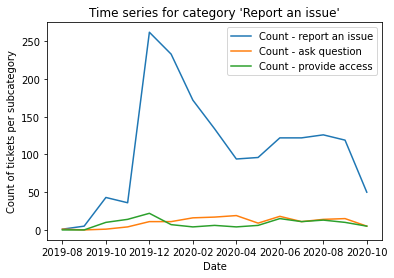

In [20]:
reportIssueTimeSeries = pd.DataFrame(report_an_issue)
reportIssueTimeSeries['Count - ask question'] = ask_question['Count - ask question']
reportIssueTimeSeries['Count - provide access'] = provide_access["Count - provide access"]
#print(reportIssueTimeSeries)
reportIssueTimeSeries.plot(x='Date').set(title="Time series for category 'Report an issue'", xlabel="Date", ylabel="Count of tickets per subcategory")


plt.show()

In [21]:
# Category: Infrastructure services
j_data_infra_serv = pd.DataFrame(j_data2.loc[j_data.category == 'Infrastructure services'])
j_data_infra_serv['subcategory'].value_counts()

server                                     482
network lan                                 39
workstation                                 23
it infrastructure purchase request           8
access                                       6
network wan                                  5
datacenter                                   4
firewall                                     3
dns (internal & external)                    2
ad/ldap/samba (authentication services)      2
database                                     1
backup                                       1
dhcp                                         1
Name: subcategory, dtype: int64

In [22]:
# Subcategory: server
server = j_data_infra_serv[j_data_infra_serv.subcategory =='server']
server = pd.DataFrame(server.groupby([j_data_infra_serv['Date']])['subcategory'].count())
server.reset_index(inplace=True)
server.columns = ["Date", "Count - server"]
#print(server)

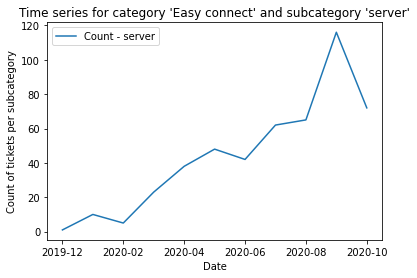

In [23]:
server.plot(x='Date').set(title="Time series for category 'Easy connect' and subcategory 'server'", xlabel="Date", ylabel="Count of tickets per subcategory")

#for x in server['Date']:
#    plt.axvline(x, color='red', linestyle='--')

plt.show()

In [32]:
#print(server)
#serverT = server.transpose()
#print(serverT)

In [ ]:
# Prophet
# Build train/test set
Enumerate = []
Subcategory = []

for i, zip in enumerate(ARmetro.columns):
    arMetroEnumerate.append(ARmetro.loc[ARmetro.loc[:,zip].first_valid_index():,zip]) # add only from first valid index
    arMetroEnumerate[i] = arMetroEnumerate[i].to_frame()
    arMetroEnumerate[i].name = zip
    zipcode = {}
    zipcode['Zip Code'] = zip
    zipNames.append(zipcode)
    arMetroEnumerate[i]['ds'] = arMetroEnumerate[i].index
    arMetroEnumerate[i].rename(columns={zip: 'y'}, inplace=True)
#    print(zip) #check to see if zip code names are saved

zipNamesDF = pd.DataFrame(zipNames)
#print(zipNamesDF)

#print(arMetroEnumerate[0].name) #data returns properly
#print(arMetroEnumerate) # View dataset of datasets

# SCRUB - BUILD TRAIN & TEST SETS:
arMetroTrain = []
arMetroTest  = []

for df in arMetroEnumerate:
   arMetroTrain.append(df[217:-13]) # represents housing value from Feb '14 - Feb '19 (5 years prior)
   arMetroTest.append(df[-13:])  # represents housing value from the last 13 months (Mar '19 - Mar '20)

#print('Train Set for AR Metros:')
#print(arMetroTrain[0])
#print('Test Set for AR Metros')
#print(arMetroTest[0][['y']])

In [ ]:
# Category: Easy connect
j_data_easy_connect = pd.DataFrame(j_data2.loc[j_data.category == 'Easy connect'])
j_data_easy_connect['subcategory'].value_counts()

report an issue    310
Name: subcategory, dtype: int64

In [363]:
# Subcategory: report an issue
report_issue = j_data_easy_connect[j_data_easy_connect.subcategory =='report an issue']
report_issue = pd.DataFrame(report_issue.groupby([j_data_easy_connect['Date']])['subcategory'].count())
report_issue.reset_index(inplace=True)
report_issue.columns = ["Date", "Count - report an issue"]
#print(report_issue)

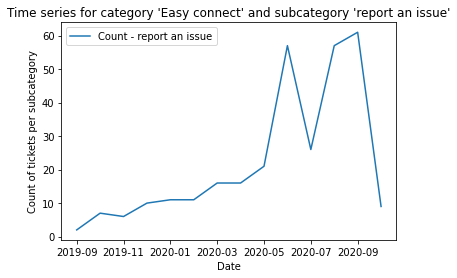

In [362]:
report_issue.plot(x='Date').set(title="Time series for category 'Easy connect' and subcategory 'report an issue'", xlabel="Date", ylabel="Count of tickets per subcategory")
plt.show()

In [ ]:
# Category: Telephone & Conference (Audio, Video)
j_data_phone = pd.DataFrame(j_data2.loc[j_data.category == 'Telephone & Conference (Audio, Video)'])
j_data_phone['subcategory'].value_counts()

telephone & services                    64
microsoft teams                          5
event/meeting support (audio visual)     4
zoom                                     2
report a telephone issue                 1
conference rooms                         1
telephone â request a new phone        1
Name: subcategory, dtype: int64

# Prophet

In [ ]:
'''
# FOR THE GROUP
# CATEGORY GROUP BY SUBCATEGORY
# NEED: date column as ds and your y var (business dur)


from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
#import Prophet for model building

# Prophet
#Plot with all ZIPs by ZIP (Hot Spring)
zil_long_HotSprings = zil_long_ar[zil_long_ar['Metro']=='Hot Springs']
hotspring_train = zil_long_HotSprings[:'2018-01-01']
hotspring_train.reset_index(inplace=True)
hotspring_train = hotspring_train.rename(columns = {'Date': 'ds', 'value': 'y'})

count = 0
grouped = hotspring_train.groupby('ZIP')
forecast_macro = pd.DataFrame() #make macro DF
for g in grouped.groups:
    group = grouped.get_group(g)

    model = Prophet()
    model.fit(group)
#Plot with all ZIPs by ZIP (Hot Spring)
zil_long_HotSprings = zil_long_ar[zil_long_ar['Metro']=='Hot Springs']
hotspring_train = zil_long_HotSprings[:'2018-01-01']
hotspring_train.reset_index(inplace=True)
hotspring_train = hotspring_train.rename(columns = {'Date': 'ds', 'value': 'y'})

count = 0
grouped = hotspring_train.groupby('ZIP')
forecast_macro = pd.DataFrame() #make macro DF
for g in grouped.groups:
    group = grouped.get_group(g)

    model = Prophet()
    model.fit(group)


    print('Forecast for ZIPcode {}'.format(HotSpring_ZIP[count]))
    

    #forecast = model.predict(hotspring_test_abv)
    future = model.make_future_dataframe(periods=12 * 3, freq='M')
    forecast = model.predict(future)
    forecast['Zip'] = HotSpring_ZIP[count]
    forecast_macro = forecast_macro.append(forecast)
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
    # plot forecast
    fig = model.plot(forecast)
    a = add_changepoints_to_plot(fig.gca(), model, forecast)
    plt.show()
    fig2 = model.plot_components(forecast)
    plt.show()

    count = count + 1

'''